
# View Lucid Dreaming Core Session Data

This notebook loads and visualizes data recorded by the `app/main.py` application.
It reads the `session_metadata.npz` file for session information and then loads the corresponding
`eeg_eog_data.dat` and `aux_sensor_data.dat` binary files.


In [14]:

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from frenztoolkit.reader import load_experiment

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics


In [15]:

# --- Configuration & Session Selection ---
BASE_RECORDING_FOLDER = "app/recorded_data"
METADATA_FILENAME = "session_metadata.npz"
EEG_EOG_DATA_FILENAME = "eeg_eog_data.dat"
AUX_SENSOR_DATA_FILENAME = "aux_sensor_data.dat"
EEG_DATA_TYPE = np.float32 # Should match what's in main.py

def list_session_folders(base_folder):
    if not os.path.isdir(base_folder):
        print(f"Error: Base recording folder not found: {base_folder}")
        return []
    sessions = sorted([d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))], reverse=True)
    return sessions

available_sessions = list_session_folders(BASE_RECORDING_FOLDER)
if not available_sessions:
    print(f"No session folders found in {BASE_RECORDING_FOLDER}")
else:
    print("Available sessions:")
    for i, session_id in enumerate(available_sessions):
        print(f"{i}: {session_id}")
    
    # Select a session (e.g., the latest one)
    selected_session_index = 0 # Or use input() for user to choose
    if 0 <= selected_session_index < len(available_sessions):
        SESSION_FOLDER_NAME = available_sessions[selected_session_index]
        SESSION_PATH = os.path.join(BASE_RECORDING_FOLDER, SESSION_FOLDER_NAME)
        print(f"\nSelected session: {SESSION_FOLDER_NAME}")
        print(f"Session path: {SESSION_PATH}")
    else:
        print("Invalid session index selected.")
        SESSION_PATH = None

Available sessions:
0: 20250527_012548_637987
1: 20250527_002748_135038
2: 20250521_001132_133620

Selected session: 20250527_012548_637987
Session path: app/recorded_data/20250527_012548_637987


In [16]:

# --- Load Metadata --- 
metadata = None
if SESSION_PATH and os.path.isdir(SESSION_PATH):
    metadata_filepath = os.path.join(SESSION_PATH, METADATA_FILENAME)
    if os.path.exists(metadata_filepath):
        try:
            metadata = np.load(metadata_filepath, allow_pickle=True)
            print("\n--- Session Metadata ---")
            for key, value in metadata.items():
                if key not in ['scores', 'eeg_eog_data_info', 'aux_sensor_data_info'] and not key.startswith("metadata_"):
                    print(f"{key}: {value}")
            
            if 'eeg_eog_data_info' in metadata:
                print("\nEEG/EOG Data Info:")
                for k,v in metadata['eeg_eog_data_info'].item().items(): # .item() if it's a 0-d array object
                    print(f"  {k}: {v}")
            if 'aux_sensor_data_info' in metadata:
                print("\nAuxiliary Sensor Data Info:")
                for k,v in metadata['aux_sensor_data_info'].item().items():
                    print(f"  {k}: {v}")
            
            # Store for later use
            eeg_eog_info = metadata['eeg_eog_data_info'].item() if 'eeg_eog_data_info' in metadata else None
            aux_info = metadata['aux_sensor_data_info'].item() if 'aux_sensor_data_info' in metadata else None
            sampling_frequency = metadata['sampling_frequency_hz'].item() if 'sampling_frequency_hz' in metadata else 250.0

        except Exception as e:
            print(f"Error loading metadata file {metadata_filepath}: {e}")
            metadata = None
    else:
        print(f"Metadata file not found: {metadata_filepath}")
else:
    print("Session path not set or invalid.")



--- Session Metadata ---
product_key: RUtYA4W3kpXi0i9C7VZCQJY5_GRhm4XL2rKp6cviwQI=
device_id: FRENZI40
session_start_iso: 2025-05-27T01:25:48.637987
sampling_frequency_hz: 125.0
audio_cue_timestamps: [1.74834225e+09 1.74834227e+09 1.74834260e+09 1.74834262e+09
 1.74834640e+09 1.74834642e+09]

EEG/EOG Data Info:
  filename: eeg_eog_data.dat
  data_type: float32
  channel_names: ['RAW_EEG_LF', 'RAW_EEG_OTEL', 'RAW_EEG_REF1', 'RAW_EEG_RF', 'RAW_EEG_OTER', 'RAW_EEG_REF2', 'FILT_EEG_LF', 'FILT_EEG_OTEL', 'FILT_EEG_RF', 'FILT_EEG_OTER', 'FILT_EOG_CH1', 'FILT_EOG_CH2', 'FILT_EOG_CH3', 'FILT_EOG_CH4']
  num_channels: 14
  shape_on_save: channels_first

Auxiliary Sensor Data Info:
  filename: aux_sensor_data.dat
  data_type: float32
  channel_names: ['FILT_EMG_CH1', 'FILT_EMG_CH2', 'FILT_EMG_CH3', 'FILT_EMG_CH4', 'RAW_IMU_X', 'RAW_IMU_Y', 'RAW_IMU_Z', 'RAW_PPG_GREEN', 'RAW_PPG_RED', 'RAW_PPG_IR']
  num_channels: 10
  shape_on_save: channels_first


In [17]:

# --- Function to Load .dat Files ---
def load_dat_file(filepath, num_channels, total_samples, dtype=np.float32):
    if not os.path.exists(filepath):
        print(f"Data file not found: {filepath}")
        return None
    try:
        data_flat = np.fromfile(filepath, dtype=dtype)
        # Expected number of elements
        expected_elements = num_channels * total_samples
        if data_flat.size != expected_elements:
            print(f"Warning: File size mismatch for {filepath}. Expected {expected_elements} elements, got {data_flat.size}.")
            # Attempt to reshape with actual elements, might lead to incorrect total_samples if file is corrupt/incomplete
            # For robust handling, one might need to adjust total_samples or num_channels based on data_flat.size
            # For now, we'll try to reshape with the number of samples that fits the channel count
            if data_flat.size % num_channels == 0:
                actual_total_samples = data_flat.size // num_channels
                if actual_total_samples != total_samples:
                    print(f"Adjusting total samples for {filepath} from {total_samples} to {actual_total_samples} based on file size.")
                total_samples = actual_total_samples
            else:
                print(f"Error: Cannot reshape data for {filepath} as size {data_flat.size} is not divisible by num_channels {num_channels}.")
                return None
        
        # Reshape to (num_channels, total_samples)
        # Data was written as (channels, samples_in_block).tobytes(), so it's C-contiguous.
        reshaped_data = data_flat.reshape(num_channels, total_samples)
        return reshaped_data
    except Exception as e:
        print(f"Error loading or reshaping data file {filepath}: {e}")
        return None


In [18]:

# --- Load EEG/EOG Data ---
eeg_eog_data_loaded = None
if metadata and eeg_eog_info and SESSION_PATH:
    eeg_eog_data_filepath = os.path.join(SESSION_PATH, EEG_EOG_DATA_FILENAME)
    num_eeg_eog_channels = eeg_eog_info['num_channels']
    
    if 'metadata_eeg_eog_sample_counts' in metadata:
        total_eeg_eog_samples = np.sum(metadata['metadata_eeg_eog_sample_counts'])
        if total_eeg_eog_samples > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, total_eeg_eog_samples, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(eeg_eog_data_filepath)
        expected_elements = file_size // (num_eeg_eog_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
        else:
            print("EEG/EOG sample counts not found in metadata.")



Loaded EEG/EOG data. Shape: (14, 2350500)


In [19]:
# --- Print First 5 Rows of EEG/EOG Data ---
if eeg_eog_data_loaded is not None:
    print("First 5 rows of EEG/EOG data (channels x samples):")
    print(eeg_eog_data_loaded[:4, :])
else:
    print("EEG/EOG data not loaded.")

First 5 rows of EEG/EOG data (channels x samples):
[[-1.4058000e+04 -1.4058000e+04 -1.4058000e+04 ...  1.2751300e+05
   1.2713300e+05  1.2712200e+05]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.2670000e+03
  -9.2780000e+03 -9.2800000e+03]
 [ 1.2439000e+05  1.1981600e+05  1.2426300e+05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.7771221e+00 -5.9416497e-01  4.5012960e-01 ... -9.0542841e+00
  -9.7580404e+00 -7.8082442e+00]]


In [20]:

# --- Load Auxiliary Sensor Data ---
aux_data_loaded = None
if metadata and aux_info and SESSION_PATH:
    aux_data_filepath = os.path.join(SESSION_PATH, AUX_SENSOR_DATA_FILENAME)
    num_aux_channels = aux_info['num_channels']
    
    if 'metadata_aux_sample_counts' in metadata:
        total_aux_samples = np.sum(metadata['metadata_aux_sample_counts'])
        if total_aux_samples > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, total_aux_samples, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("No Auxiliary sensor samples recorded according to metadata.")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(aux_data_filepath)
        expected_elements = file_size // (num_aux_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("Auxiliary sensor sample counts not found in metadata.")



Loaded Auxiliary sensor data. Shape: (10, 2350500)


In [21]:
# --- Print First 5 Rows of Auxiliary Sensor Data ---
if aux_data_loaded is not None:
    print("First 5 rows of Auxiliary sensor data (channels x samples):")
    print(aux_data_loaded[:5, :])
else:
    print("Auxiliary sensor data not loaded.")


First 5 rows of Auxiliary sensor data (channels x samples):
[[ 7.8025246e+00  7.7229409e+00  2.9949923e+00 ... -2.9345584e+00
  -1.3806226e+00  2.0078251e+00]
 [ 4.2415627e+01  3.5371876e+01  3.9965626e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.2638700e+05  1.2640000e+05  1.2639000e+05 ... -1.5149444e+00
   2.1228364e+00 -1.6225448e+00]
 [ 1.8856825e-01  1.9765750e-01  1.5400001e-01 ... -3.9322501e+02
  -3.9460312e+02 -3.9399063e+02]
 [ 4.6442813e+02  4.6795001e+02  4.6703125e+02 ...  2.1312800e+05
   2.1308800e+05  2.1307900e+05]]


(2901510, 6)
2025-05-27T01:25:48.637987

--- Saved Scores (from session_metadata.npz) ---

Score: array__sleep_stage (Length: 754), First 10 values: [0 0 0 0 0 0 0 0 0 0]

Score: array__poas (Length: 754), First 10 values: [2.62777394e-06 1.81667712e-04 8.48370734e-05 5.43347806e-03
 3.01485055e-03 1.77897800e-01 8.02365424e-02 4.77982970e-02
 2.54698225e-02 6.78077823e-02]

Score: array__posture (Length: 4176), First 10 values: ['upright' 'upright' 'prone' 'prone' 'upright' 'upright' 'upright' 'prone'
 'prone' 'prone']

Score: array__focus_score (Length: 9402), First 10 values: [40.         40.         40.         40.         40.         40.
 39.47839345 38.48091558 37.40891665 35.61045946]

Score: array__sqc_scores (Length: 4176), First 10 values: [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 1 0]
 [1 0 1 0]]

--- Generating Original Plot (30s Interval) ---


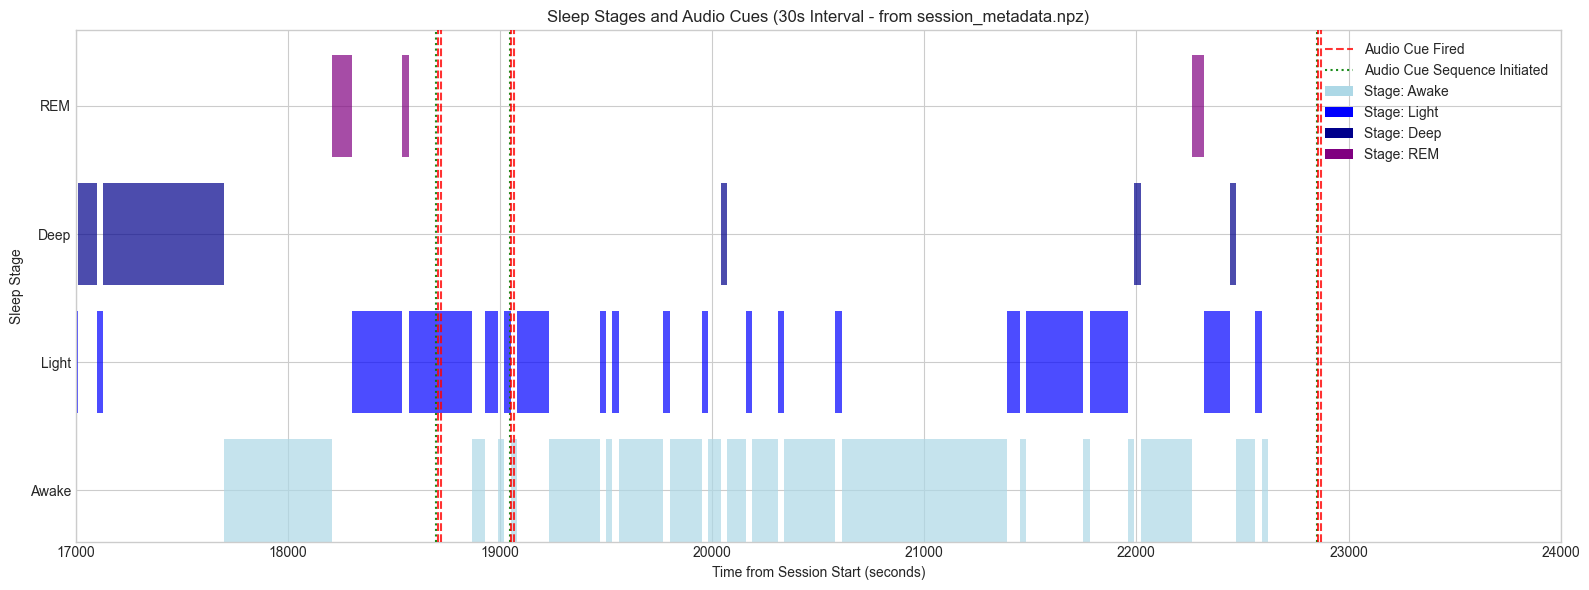


Original Plot - Audio Cues Fired (absolute timestamps, full session): [1.74834225e+09 1.74834227e+09 1.74834260e+09 1.74834262e+09
 1.74834640e+09 1.74834642e+09]
Original Plot - Audio Cues Fired (seconds from session start, full session): [18705.14 18722.16 19050.19 19067.16 22855.02 22871.99]
Original Plot - Audio Cues Fired (seconds from session start, PLOTTED SLICE): [18705.14 18722.16 19050.19 19067.16 22855.02 22871.99]
Original Plot - Audio Cue Sequence Initiations (seconds from session start, full session): [18700.14 19045.19 22850.02]
Original Plot - Audio Cue Sequence Initiations (seconds from session start, PLOTTED SLICE): [18700.14 19045.19 22850.02]

--- Adjusted Sleep Stage Interval Calculation ---
Total raw EEG samples (from load_experiment): 2901510
Assumed sampling frequency for adjustment: 125.0 Hz
Calculated total duration of EEG data (from load_experiment): 23212.08 seconds
Number of sleep stages: 754
ADJUSTED SLEEP STAGE INTERVAL: 30.79 seconds/stage

--- Generati

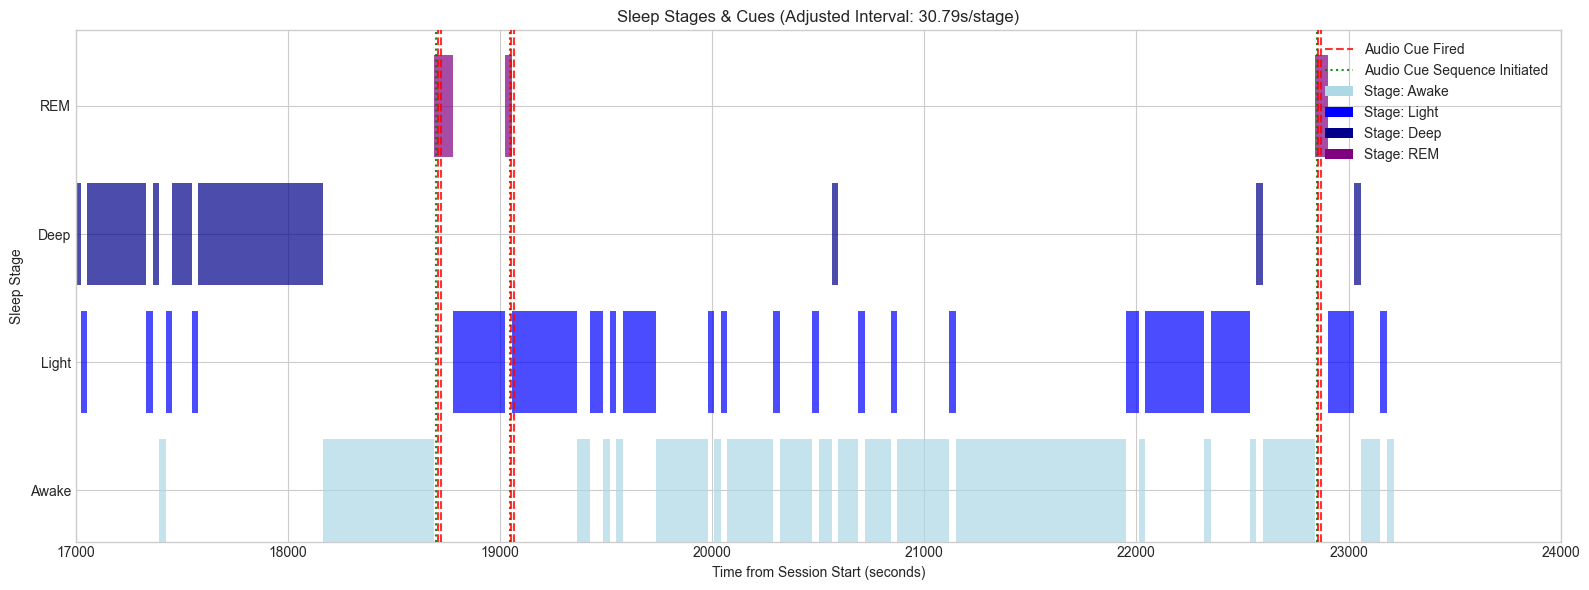

Adjusted Plot - Audio Cues Fired (seconds from session start, PLOTTED SLICE): [18705.14 18722.16 19050.19 19067.16 22855.02 22871.99]
Adjusted Plot - Audio Cue Sequence Initiations (seconds from session start, PLOTTED SLICE): [18700.14 19045.19 22850.02]


In [41]:
data = load_experiment(
    "app/recorded_data/20250527_012548_637987/1748323554.397378")
# If data is loaded, print some basic information
print(data.get("DATA", {}).get("RAW").get("EEG").shape)

# --- Display Scores and Audio Cues ---
if metadata and 'scores' in metadata and 'session_start_iso' in metadata:
    scores_dict = metadata['scores'].item()
    print(metadata['session_start_iso'])
    session_start_iso_str = str(metadata['session_start_iso'].item())
    audio_cue_timestamps_abs = metadata.get('audio_cue_timestamps') 

    # --- Plot Configuration ---
    AUDIO_CUE_PRE_DELAY_S = 5.0  
    AUDIO_CUES_PER_SEQUENCE = 2 
    PLOT_SLICE_START_S = 17000  # Or specify a start time in seconds, e.g., 0
    PLOT_SLICE_END_S = 24000    # Or specify an end time in seconds, e.g., 1800
    # --- End Plot Configuration ---

    print("\n--- Saved Scores (from session_metadata.npz) ---")
    for score_name, score_array in scores_dict.items():
        if isinstance(score_array, np.ndarray) and score_array.size > 10:
            print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'}), First 10 values: {score_array[:10]}")
        else:
            print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'})")
            print(score_array)

    sleep_stages_all = scores_dict.get("array__sleep_stage")

    if sleep_stages_all is not None and hasattr(sleep_stages_all, '__len__') and len(sleep_stages_all) > 0:
        try:
            session_start_dt = datetime.fromisoformat(session_start_iso_str)
            session_start_timestamp = session_start_dt.timestamp()
            valid_start_time = True
        except ValueError:
            print(f"Error: session_start_iso '{session_start_iso_str}' is not a valid ISO format. Cannot calculate relative cue times.")
            valid_start_time = False

        SLEEP_STAGE_INTERVAL_S = 30.0 
        sleep_stage_time_axis_full_s = np.arange(len(sleep_stages_all)) * SLEEP_STAGE_INTERVAL_S

        # --- Apply Slicing for First Plot --- 
        slice_indices = np.ones(len(sleep_stages_all), dtype=bool)
        
        # Determine xlim for the first plot
        xlim_start_orig = PLOT_SLICE_START_S if PLOT_SLICE_START_S is not None else (sleep_stage_time_axis_full_s[0] if len(sleep_stage_time_axis_full_s) > 0 else 0)
        xlim_end_orig = PLOT_SLICE_END_S if PLOT_SLICE_END_S is not None else (sleep_stage_time_axis_full_s[-1] + SLEEP_STAGE_INTERVAL_S if len(sleep_stage_time_axis_full_s) > 0 else 0)

        if PLOT_SLICE_START_S is not None:
            slice_indices &= (sleep_stage_time_axis_full_s + SLEEP_STAGE_INTERVAL_S > PLOT_SLICE_START_S) 
        if PLOT_SLICE_END_S is not None:
            slice_indices &= (sleep_stage_time_axis_full_s < PLOT_SLICE_END_S) 
            
        sleep_stages_orig_plot = sleep_stages_all[slice_indices]
        sleep_stage_time_axis_orig_plot_s = sleep_stage_time_axis_full_s[slice_indices]

        if len(sleep_stages_orig_plot) == 0:
            print(f"No sleep stage data in the selected slice for the original plot: {PLOT_SLICE_START_S}s - {PLOT_SLICE_END_S}s. Cannot plot.")
        else:
            print("\n--- Generating Original Plot (30s Interval) ---")
            plt.figure(figsize=(16, 6)) 
            
            sleep_stage_colors = {
                -1: 'gray', 0: 'lightblue', 1: 'blue', 2: 'darkblue', 3: 'purple'
            }
            sleep_stage_labels = {
                -1: 'Undefined', 0: 'Awake', 1: 'Light', 2: 'Deep', 3: 'REM'
            }
            
            unique_stages_in_data = np.unique(sleep_stages_all) 
            for stage_val in unique_stages_in_data:
                if stage_val in sleep_stage_labels:
                     plt.bar(0, 0, width=0, color=sleep_stage_colors.get(stage_val, 'black'), label=f"Stage: {sleep_stage_labels[stage_val]}")

            for i, stage in enumerate(sleep_stages_orig_plot):
                start_time = sleep_stage_time_axis_orig_plot_s[i]
                bar_width = SLEEP_STAGE_INTERVAL_S
                
                # Adjust bar drawing for slice edges
                effective_bar_start = start_time
                if PLOT_SLICE_START_S is not None and start_time < PLOT_SLICE_START_S:
                    effective_bar_start = PLOT_SLICE_START_S
                    bar_width = (start_time + SLEEP_STAGE_INTERVAL_S) - PLOT_SLICE_START_S
                if PLOT_SLICE_END_S is not None and start_time + SLEEP_STAGE_INTERVAL_S > PLOT_SLICE_END_S:
                    # If original start was already adjusted, this needs to be relative to original start_time
                    if effective_bar_start == PLOT_SLICE_START_S : # Bar started before or at slice_start
                         bar_width = PLOT_SLICE_END_S - PLOT_SLICE_START_S if start_time < PLOT_SLICE_START_S else PLOT_SLICE_END_S - start_time
                    else: # Bar started within slice
                        bar_width = PLOT_SLICE_END_S - start_time

                if bar_width <= 0: continue 
                
                color = sleep_stage_colors.get(stage, 'black') 
                plt.bar(effective_bar_start, bottom=stage-0.4, height=0.8, width=bar_width, 
                        color=color, align='edge', alpha=0.7)
            
            current_ylim = plt.ylim()

            plotted_cues = False
            plotted_initiations = False
            if valid_start_time and audio_cue_timestamps_abs is not None and hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                if not isinstance(audio_cue_timestamps_abs, np.ndarray) or audio_cue_timestamps_abs.dtype != np.float64:
                     audio_cue_timestamps_abs = np.array(audio_cue_timestamps_abs, dtype=np.float64)
                
                relative_audio_cue_times_s_all = audio_cue_timestamps_abs - session_start_timestamp
                
                cue_slice_indices = (relative_audio_cue_times_s_all >= xlim_start_orig) & (relative_audio_cue_times_s_all <= xlim_end_orig)
                relative_audio_cue_times_s_plot = relative_audio_cue_times_s_all[cue_slice_indices]

                if len(relative_audio_cue_times_s_plot) > 0:
                    plt.vlines(relative_audio_cue_times_s_plot, ymin=current_ylim[0], ymax=current_ylim[1], 
                               colors='red', linestyles='dashed', label='Audio Cue Fired', zorder=5, alpha=0.8)
                    plotted_cues = True

                audio_cue_initiation_times_s_all = []
                if len(relative_audio_cue_times_s_all) >= AUDIO_CUES_PER_SEQUENCE: 
                    for i in range(0, len(relative_audio_cue_times_s_all), AUDIO_CUES_PER_SEQUENCE):
                        if i < len(relative_audio_cue_times_s_all):
                            first_cue_in_sequence_time = relative_audio_cue_times_s_all[i]
                            initiation_time = first_cue_in_sequence_time - AUDIO_CUE_PRE_DELAY_S
                            audio_cue_initiation_times_s_all.append(initiation_time)
                
                initiation_slice_indices = (np.array(audio_cue_initiation_times_s_all) >= xlim_start_orig) & (np.array(audio_cue_initiation_times_s_all) <= xlim_end_orig)
                audio_cue_initiation_times_s_plot = np.array(audio_cue_initiation_times_s_all)[initiation_slice_indices]
                
                if len(audio_cue_initiation_times_s_plot) > 0:
                    plt.vlines(audio_cue_initiation_times_s_plot, ymin=current_ylim[0], ymax=current_ylim[1], 
                               colors='green', linestyles='dotted', label='Audio Cue Sequence Initiated', zorder=4, alpha=0.9)
                    plotted_initiations = True
            
            plt.title("Sleep Stages and Audio Cues (30s Interval - from session_metadata.npz)")
            plt.xlabel(f"Time from Session Start (seconds)") 
            plt.ylabel("Sleep Stage")
            plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
            plt.legend(loc='upper right') 
            plt.grid(True, axis='x') 
            plt.ylim(current_ylim) 
            plt.xlim(xlim_start_orig, xlim_end_orig)
            plt.tight_layout()
            plt.show()

            if valid_start_time and audio_cue_timestamps_abs is not None:
                if hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                    print(f"\nOriginal Plot - Audio Cues Fired (absolute timestamps, full session): {audio_cue_timestamps_abs}")
                    print(f"Original Plot - Audio Cues Fired (seconds from session start, full session): {np.round(relative_audio_cue_times_s_all, 2)}")
                    if plotted_cues: 
                         print(f"Original Plot - Audio Cues Fired (seconds from session start, PLOTTED SLICE): {np.round(relative_audio_cue_times_s_plot, 2)}")
                    if audio_cue_initiation_times_s_all: 
                        print(f"Original Plot - Audio Cue Sequence Initiations (seconds from session start, full session): {np.round(audio_cue_initiation_times_s_all, 2)}")
                    if plotted_initiations: 
                        print(f"Original Plot - Audio Cue Sequence Initiations (seconds from session start, PLOTTED SLICE): {np.round(audio_cue_initiation_times_s_plot, 2)}")
                elif not plotted_cues and not plotted_initiations: 
                    print("\nOriginal Plot - Audio cue timestamp data found but was empty or all cues/initiations outside selected slice. No cues plotted.")
            elif audio_cue_timestamps_abs is None:
                 print("\nOriginal Plot - Audio cue timestamps (key 'audio_cue_timestamps') not found in metadata. Cannot plot cues.")
        
        # --- Adjusted Interval Plot ---
        if data and hasattr(data, 'get'):
            raw_eeg_data_info = data.get("DATA", {}).get("RAW", {}).get("EEG")
            if raw_eeg_data_info is not None and hasattr(raw_eeg_data_info, 'shape') and raw_eeg_data_info.shape[0] > 0:
                total_raw_eeg_samples = raw_eeg_data_info.shape[0]
                FS_FOR_ADJUSTMENT = 125.0  # Samples per second as per user's info for load_experiment data
                
                if len(sleep_stages_all) > 0 and FS_FOR_ADJUSTMENT > 0:
                    actual_total_duration_s = total_raw_eeg_samples / FS_FOR_ADJUSTMENT
                    adjusted_sleep_stage_interval_s = actual_total_duration_s / len(sleep_stages_all)
                    
                    print(f"\n--- Adjusted Sleep Stage Interval Calculation ---")
                    print(f"Total raw EEG samples (from load_experiment): {total_raw_eeg_samples}")
                    print(f"Assumed sampling frequency for adjustment: {FS_FOR_ADJUSTMENT} Hz")
                    print(f"Calculated total duration of EEG data (from load_experiment): {actual_total_duration_s:.2f} seconds")
                    print(f"Number of sleep stages: {len(sleep_stages_all)}")
                    print(f"ADJUSTED SLEEP STAGE INTERVAL: {adjusted_sleep_stage_interval_s:.2f} seconds/stage")

                    sleep_stage_time_axis_full_adj_s = np.arange(len(sleep_stages_all)) * adjusted_sleep_stage_interval_s

                    # Apply Slicing for Adjusted Plot
                    slice_indices_adj = np.ones(len(sleep_stages_all), dtype=bool)
                    xlim_start_adj = PLOT_SLICE_START_S if PLOT_SLICE_START_S is not None else (sleep_stage_time_axis_full_adj_s[0] if len(sleep_stage_time_axis_full_adj_s) > 0 else 0)
                    xlim_end_adj = PLOT_SLICE_END_S if PLOT_SLICE_END_S is not None else (sleep_stage_time_axis_full_adj_s[-1] + adjusted_sleep_stage_interval_s if len(sleep_stage_time_axis_full_adj_s) > 0 else 0)

                    if PLOT_SLICE_START_S is not None:
                        slice_indices_adj &= (sleep_stage_time_axis_full_adj_s + adjusted_sleep_stage_interval_s > PLOT_SLICE_START_S)
                    if PLOT_SLICE_END_S is not None:
                        slice_indices_adj &= (sleep_stage_time_axis_full_adj_s < PLOT_SLICE_END_S)
                        
                    sleep_stages_adj_plot = sleep_stages_all[slice_indices_adj]
                    sleep_stage_time_axis_adj_plot_s = sleep_stage_time_axis_full_adj_s[slice_indices_adj]

                    if len(sleep_stages_adj_plot) == 0:
                        print(f"No sleep stage data in the selected slice for the adjusted plot: {PLOT_SLICE_START_S}s - {PLOT_SLICE_END_S}s.")
                    else:
                        print("\n--- Generating Adjusted Plot ---")
                        plt.figure(figsize=(16, 6))
                        
                        # Legend (same as before)
                        for stage_val in unique_stages_in_data: # unique_stages_in_data defined from first plot
                            if stage_val in sleep_stage_labels:
                                 plt.bar(0, 0, width=0, color=sleep_stage_colors.get(stage_val, 'black'), label=f"Stage: {sleep_stage_labels[stage_val]}")

                        for i, stage in enumerate(sleep_stages_adj_plot):
                            start_time = sleep_stage_time_axis_adj_plot_s[i]
                            bar_width = adjusted_sleep_stage_interval_s

                            effective_bar_start = start_time
                            if PLOT_SLICE_START_S is not None and start_time < PLOT_SLICE_START_S:
                                effective_bar_start = PLOT_SLICE_START_S
                                bar_width = (start_time + adjusted_sleep_stage_interval_s) - PLOT_SLICE_START_S
                            if PLOT_SLICE_END_S is not None and start_time + adjusted_sleep_stage_interval_s > PLOT_SLICE_END_S:
                                if effective_bar_start == PLOT_SLICE_START_S:
                                     bar_width = PLOT_SLICE_END_S - PLOT_SLICE_START_S if start_time < PLOT_SLICE_START_S else PLOT_SLICE_END_S - start_time
                                else:
                                    bar_width = PLOT_SLICE_END_S - start_time
                            
                            if bar_width <= 0: continue
                            
                            color = sleep_stage_colors.get(stage, 'black')
                            plt.bar(effective_bar_start, bottom=stage-0.4, height=0.8, width=bar_width,
                                    color=color, align='edge', alpha=0.7)
                        
                        current_ylim_adj = plt.ylim() # Capture new ylim

                        # Audio Cues for Adjusted Plot (logic is similar, using xlim_start_adj, xlim_end_adj for filtering)
                        plotted_cues_adj = False
                        plotted_initiations_adj = False
                        if valid_start_time and audio_cue_timestamps_abs is not None and hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                            # relative_audio_cue_times_s_all and audio_cue_initiation_times_s_all are already calculated from before
                            cue_slice_indices_adj = (relative_audio_cue_times_s_all >= xlim_start_adj) & (relative_audio_cue_times_s_all <= xlim_end_adj)
                            relative_audio_cue_times_s_adj_plot = relative_audio_cue_times_s_all[cue_slice_indices_adj]

                            if len(relative_audio_cue_times_s_adj_plot) > 0:
                                plt.vlines(relative_audio_cue_times_s_adj_plot, ymin=current_ylim_adj[0], ymax=current_ylim_adj[1],
                                           colors='red', linestyles='dashed', label='Audio Cue Fired', zorder=5, alpha=0.8)
                                plotted_cues_adj = True

                            initiation_slice_indices_adj = (np.array(audio_cue_initiation_times_s_all) >= xlim_start_adj) & (np.array(audio_cue_initiation_times_s_all) <= xlim_end_adj)
                            audio_cue_initiation_times_s_adj_plot = np.array(audio_cue_initiation_times_s_all)[initiation_slice_indices_adj]
                            
                            if len(audio_cue_initiation_times_s_adj_plot) > 0:
                                plt.vlines(audio_cue_initiation_times_s_adj_plot, ymin=current_ylim_adj[0], ymax=current_ylim_adj[1],
                                           colors='green', linestyles='dotted', label='Audio Cue Sequence Initiated', zorder=4, alpha=0.9)
                                plotted_initiations_adj = True
                        
                        plt.title(f"Sleep Stages & Cues (Adjusted Interval: {adjusted_sleep_stage_interval_s:.2f}s/stage)")
                        plt.xlabel(f"Time from Session Start (seconds)")
                        plt.ylabel("Sleep Stage")
                        plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
                        plt.legend(loc='upper right')
                        plt.grid(True, axis='x')
                        plt.ylim(current_ylim_adj) # Use ylim captured for this plot
                        plt.xlim(xlim_start_adj, xlim_end_adj)
                        plt.tight_layout()
                        plt.show()
                        
                        # Print statements for adjusted plot cues
                        if valid_start_time and audio_cue_timestamps_abs is not None:
                            if hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                                # Full session times already printed for original plot, can be skipped or repeated if desired
                                if plotted_cues_adj: 
                                     print(f"Adjusted Plot - Audio Cues Fired (seconds from session start, PLOTTED SLICE): {np.round(relative_audio_cue_times_s_adj_plot, 2)}")
                                if plotted_initiations_adj: 
                                    print(f"Adjusted Plot - Audio Cue Sequence Initiations (seconds from session start, PLOTTED SLICE): {np.round(audio_cue_initiation_times_s_adj_plot, 2)}")
                            elif not plotted_cues_adj and not plotted_initiations_adj:
                                print("\nAdjusted Plot - Audio cue timestamp data found but was empty or all cues/initiations outside selected slice. No cues plotted.")
                        # No need for the 'audio_cue_timestamps_abs is None' here as it's covered by original plot's prints

                else: # Conditions for adjustment calculation not met
                    if not (len(sleep_stages_all) > 0): print("\nAdjusted Plot: No sleep stages available for interval calculation.")
                    elif not (FS_FOR_ADJUSTMENT > 0): print("\nAdjusted Plot: Sampling frequency for adjustment is not positive.")
            else: # raw_eeg_data_info issues
                print("\nAdjusted Plot: Could not retrieve valid EEG data shape from load_experiment data.")
        else: # data from load_experiment issues
            print("\nAdjusted Plot: Data from load_experiment not available.")

    elif sleep_stages_all is not None: 
        print("Sleep stage data in metadata is empty. Cannot plot.")
    else: 
        print("Sleep stage data ('array__sleep_stage') not found in metadata scores. Cannot plot sleep stages and cues from metadata.")

elif not metadata:
    print("Metadata object not loaded. Cannot process scores or cues.")
elif 'scores' not in metadata :
    print("Key 'scores' not found in metadata.")
elif 'session_start_iso' not in metadata :
    print("Key 'session_start_iso' not found in metadata (needed for plotting audio cues relative to session start).")

# Fallback plotting does not currently support slicing, it will show the full data from Frenz toolkit.
if not (metadata and 'scores' in metadata and metadata['scores'].item().get("array__sleep_stage") is not None and \
    len(metadata['scores'].item().get("array__sleep_stage")) > 0 and 'session_start_iso' in metadata) :
    
    print("\n--- Attempting Fallback: Load Sleep Stages with Frenz Toolkit ---")
    if SESSION_PATH and os.path.isdir(SESSION_PATH):
        session_subfolders = [d for d in os.listdir(SESSION_PATH) if os.path.isdir(os.path.join(SESSION_PATH, d))]
        
        if session_subfolders:
            session_subfolder_for_frenz = os.path.join(SESSION_PATH, session_subfolders[0])
            print(f"Attempting to load Frenz experiment data from subfolder: {session_subfolder_for_frenz}")
            
            try:
                session_data = load_experiment(session_subfolder_for_frenz)
                sleep_stage_list = session_data.get("SCORE", {}).get("array__sleep_stage")

                if sleep_stage_list is not None and len(sleep_stage_list) > 0:
                    plt.figure(figsize=(12, 3))
                    SLEEP_STAGE_INTERVAL_S_FRENZ = 30.0 
                    score_time_axis = np.arange(len(sleep_stage_list)) * SLEEP_STAGE_INTERVAL_S_FRENZ
                    for i, stage in enumerate(sleep_stage_list):
                        start_time = score_time_axis[i]
                        color = sleep_stage_colors.get(stage, 'black') 
                        plt.bar(start_time, bottom=stage-0.4, height=0.8, width=SLEEP_STAGE_INTERVAL_S_FRENZ, 
                                color=color, align='edge', alpha=0.7)

                    plt.title("Sleep Stages Over Session (from Frenz Toolkit data)")
                    plt.xlabel(f"Time (seconds)")
                    plt.ylabel("Sleep Stage")
                    plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
                    unique_fallback_stages = np.unique(sleep_stage_list)
                    for stage_val in unique_fallback_stages:
                        if stage_val in sleep_stage_labels:
                            plt.bar(0, 0, width=0, color=sleep_stage_colors.get(stage_val, 'black'), label=f"Stage: {sleep_stage_labels[stage_val]}")
                    plt.legend(loc='upper right')
                    plt.grid(True, axis='x')
                    plt.show()
                else:
                    print("No sleep stage data available in Frenz Toolkit session data or data format unexpected.")
            except FileNotFoundError:
                print(f"Frenz experiment data not found in expected subfolder: {session_subfolder_for_frenz}")
            except Exception as e:
                print(f"Error loading or plotting data using Frenz Toolkit: {e}")
        else:
            print(f"No subdirectories found in {SESSION_PATH} to attempt loading Frenz experiment data from.")
    else:
        print("SESSION_PATH not set, cannot attempt Frenz Toolkit fallback.")